# *Personal medical cost*

Health problems and the high cost of medical services make it an extremely important part of our lives to have health insurance. Not only does it help to cover the cost of any treatment or surgery, but it also gives you the peace of mind that - in the case of an accident - you won't end up with a huge bill that you'll be paying for for the next decade. 

**Columns:**

+ **age**: age of primary beneficiary,
+ **sex**: insurance contractor gender, female, male,
+ **bmi**: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9,
+ **children**: number of children covered by health insurance / Number of dependents,
+ **smoker**: smoking,
+ **region**: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest,
+ **charges**: Individual medical costs billed by health insurance.

The above set of variables will not only allow us to build a regression model that determines the value of the dependent variable: charges, but it can also be used to test some interesting statistical hypotheses.

## Main goal
Build a regression model that determines individual medical costs billed by health insurance.

## Side goal
Using selected statistical tests, check whether: 
+ women and men differ by bmi or smoking,
+ smoking is associated with being overweight,
+ regions differ by the amount of insurance paid.

# libraries and data loading

In [102]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, shapiro, mannwhitneyu, chi2_contingency

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
df = pd.read_csv("C:/Users/chole/Desktop/Personal_medical_cost/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [35]:
df.shape

(1338, 7)

In [36]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

# Basic overview

## Uniques values

We have four quality variables, so let's look at how many individual values they have.

In [7]:
df.drop(columns=['age', 'bmi', 'charges']).nunique()

sex         2
children    6
smoker      2
region      4
dtype: int64

In [8]:
list(df.region.unique())

['southwest', 'southeast', 'northwest', 'northeast']

In [9]:
list(df.children.sort_values().unique())

[0, 1, 2, 3, 4, 5]

We have four regions and the number of children range from 0 to 5.

## Descriptive statistics

In [10]:
df.loc[:,["age", "bmi", "charges"]].describe()

,age,bmi,charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,13270.422265
std,14.049960,6.098187,12110.011237
min,18.000000,15.960000,1121.873900
25%,27.000000,26.296250,4740.287150
50%,39.000000,30.400000,9382.033000
75%,51.000000,34.693750,16639.912515
max,64.000000,53.130000,63770.428010


On average: 
+ age of the respondents is 39,  
+ the respondents are obese. 

The cost of health insurance has a very high standard deviation, so I don't think an average value would be adequate to approximate it.

In [11]:
# coefficient of variation
def cv(x): return np.std(x) / np.mean(x) * 100
df.loc[:, ["age", "bmi", "charges"]].apply(cv)

age        35.821919
bmi        19.880079
charges    91.221551
dtype: float64

The bmi shows the least variability.

In [12]:
df.loc[:, ["age", "bmi", "charges"]].apply(kurtosis, bias=False)

age       -1.245088
bmi       -0.050732
charges    1.606299
dtype: float64

Kurtosis is a measure of outliers. The higher its value, the more likely there are outliers in the database. The lower the value, the more the results are clustered around the mean.

The safe threshold of $K=|3|$ was not exceeded for any variable.

In [13]:
df.loc[:, ["age", "bmi", "charges"]].apply(skew, bias=False)

age        0.055673
bmi        0.284047
charges    1.515880
dtype: float64

The amount of charges has a high positive skewness value so that the distribution should be stretched to the right. This means that the vast majority of cases should fall within the smaller range of payouts, but there will also be cases of large payouts.

In [28]:
# alpha = 0.05
# H0 = The sample comes from a normal distribution.
# H1 = The sample is not coming from a normal distribution.

df[["age", "bmi", "charges"]].apply(shapiro, axis=0).T

,0,1
age,0.944699,5.687480e-22
bmi,0.993888,2.609842e-05
charges,0.814688,1.150478e-36


column 0 - statistic <br />
column 1 - p-value

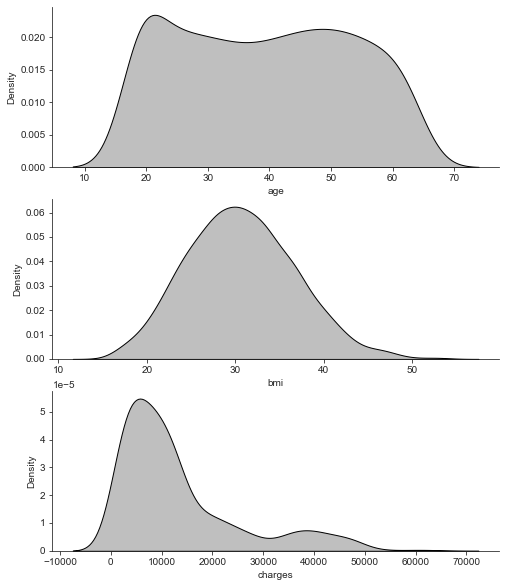

In [20]:
count = 1
# Removal of top and right side of axis
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# Setting the chart display style
sns.set_style(style="ticks", rc=custom_params)
# Setting the chart size
plt.pyplot.subplots(figsize=(8, 10))

# Loop to make graphs
for col in df[["age", "bmi", "charges"]]:
    plt.pyplot.subplot(3,1, count)
    sns.kdeplot(df[col],
                shade=True,
                color='k')
    count+=1

Our quantitative data do not follow a normal distribution.

## Missing values

In [16]:
df.isnull().sum()/len(df)*100

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

The database is complete.

# Statistical hypotheses

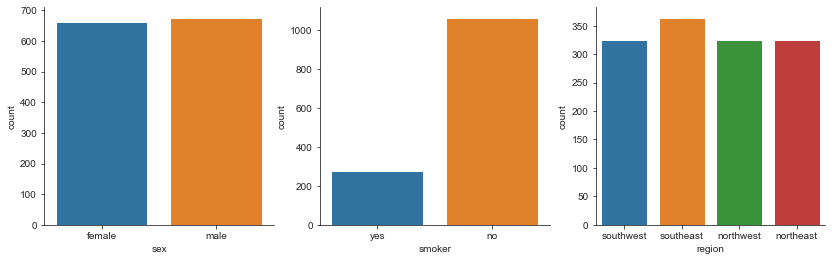

In [53]:
count = 1
# Removal of top and right side of axis
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
# Setting the chart display style
sns.set_style(style="ticks", rc=custom_params)
# Setting the chart size
plt.pyplot.subplots(figsize=(14, 4))

# Loop to make graphs
for col in df[["sex", "smoker", "region"]]:
    plt.pyplot.subplot(1,3, count)
    sns.countplot(df[col])
    count+=1

We have approximately as many women as men and as many people from different regions. It is true that the *southwest* has slightly more people, but it is not a very big difference.

We do, however, have far fewer people who smoke cigarettes.

## Normality test among groups

>H0: the data was drawn from a normal distribution <br />
>H1: the data was drawn from a non normal distribution

$\alpha = 0.05$

In [81]:
df_female = df.loc[df.loc[:,"sex"]=="female"]
df_male = df.loc[df.loc[:,"sex"]=="male"]

df_smoker = df.loc[df.loc[:,"smoker"]=="yes"]
df_n_smoker = df.loc[df.loc[:,"smoker"]=="no"]

df_southW = df.loc[df.loc[:,"region"]=="southwest"]
df_southE = df.loc[df.loc[:,"region"]=="southeast"]
df_northW = df.loc[df.loc[:,"region"]=="northwest"]
df_northE = df.loc[df.loc[:,"region"]=="northeast"]

data_sets = [df_male, df_female, df_smoker, df_n_smoker, df_southW, df_southE, df_northW, df_northE]

In [91]:
p1 = df_male.loc[:, ["age", "bmi", "charges"]].apply(shapiro)
print("Male")
print(p1)
p2 = df_female.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("Female")
print(p2)
p3 = df_smoker.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("Smoker")
print(p3)
p4 = df_n_smoker.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("Non smoker")
print(p4)
p5 = df_southW.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("southwest")
print(p5)
p6 = df_southE.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("southeast")
print(p6)
p7 = df_northW.loc[:, ["age", "bmi", "charges"]].apply(shapiro) 
print("northwest")
print(p7)
p8 = df_northE.loc[:, ["age", "bmi", "charges"]].apply(shapiro)
print("northeast")
print(p8)

Male
            age       bmi       charges
0  9.438887e-01  0.993048  8.228140e-01
1  2.624835e-15  0.003131  1.178851e-26
Female
            age       bmi       charges
0  9.453153e-01  0.993026  8.053942e-01
1  6.549281e-15  0.003543  1.830528e-27
Smoker
            age       bmi       charges
0  9.481711e-01  0.990856  9.395522e-01
1  2.889620e-08  0.085191  3.625188e-09
Non smoker
            age       bmi       charges
0  9.429171e-01  0.994250  8.728628e-01
1  8.044311e-20  0.000421  1.445590e-28
southwest
            age       bmi       charges
0  9.407403e-01  0.994927  7.842954e-01
1  4.063502e-10  0.363001  2.023704e-20
southeast
            age       bmi       charges
0  9.451167e-01  0.991089  8.242298e-01
1  2.290088e-10  0.027041  1.232663e-19
northwest
            age       bmi       charges
0  9.386048e-01  0.995464  8.128033e-01
1  2.394839e-10  0.465452  4.268424e-19
northeast
            age       bmi       charges
0  9.445760e-01  0.992033  8.353428e-01
1  1.13352

## whether women and men differ by bmi or smoking

In [92]:
print("Male")
print(p1)
print()
print("Female")
print(p2)

Male
            age       bmi       charges
0  9.438887e-01  0.993048  8.228140e-01
1  2.624835e-15  0.003131  1.178851e-26

Female
            age       bmi       charges
0  9.453153e-01  0.993026  8.053942e-01
1  6.549281e-15  0.003543  1.830528e-27


At the alpha level of significance, we reject H0 in favor of H1. That is, the distribution of BMI in the male and female groups does not follow a normal distribution.

In [96]:
df.loc[:,["sex","bmi"]].groupby("sex").mean()

,bmi
sex,
female,30.377749
male,30.943129


**The Mann-Whitney U test** is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution. The test determines whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution [(Source)](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/).

> H0: the sample distributions are equal. <br />
> H1: the sample distributions are not equal.

$\alpha = 0.05$

In [98]:
mannwhitneyu(df_female[["bmi"]], df_male[["bmi"]])

MannwhitneyuResult(statistic=array([212180.]), pvalue=array([0.10140128]))

The test result does not allow us to reject H0. It is concluded that *bmi* does not depend on *gender*. 

In [101]:
smoker_gender_crosstable = pd.crosstab(df.loc[:, "sex"], df.loc[:, "smoker"])
smoker_gender_crosstable

smoker,no,yes
sex,,
female,547,115
male,517,159


**The Chi-square test of independence** is one of the most useful statistics for testing hypotheses when the variables are nominal, as often happens in clinical research. Unlike most statistics, the Chi-squarecan provide information not only on the significance of any observed differences, but also provides detailed information on exactly which categories account for any differences found. Thus, the amount and detail of information this statistic can provide renders it one of the most useful tools in the researcher’s array of available analysis tools [(Source)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900058/). 

> H0: the features are independent. <br />
> H1: the features are not independent.

$\alpha = 0.05$

In [103]:
chi2_contingency(smoker_gender_crosstable)

(7.39291081459996,
 0.006548143503580696,
 1,
 array([[526.43348281, 135.56651719],
        [537.56651719, 138.43348281]]))

We reject H0 in favor of H1. Gender and smoking are dependent on each other.

## whether smoking is associated with being overweight

## whether regions differ by the amount of insurance paid